In [1]:
# math
import numpy as np
from lmfit.models import LorentzianModel, LinearModel, QuadraticModel, Model
from scipy.signal import savgol_filter
from scipy.integrate import quad, dblquad
from scipy.optimize import fsolve
import scipy
import math
import matplotlib
import random

# file management
import re
import natsort
import os

# Image loading
from IPython.display import Image

# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.cm as cmaps
from matplotlib.colors import LightSource
from matplotlib import rc
import matplotlib.pyplot as plt

# image processing
from scipy.ndimage.filters import gaussian_filter
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

# my functions
def fmt(x,pos):
    return r'$10^{{{:.0f}}}$'.format(x)

def chunks(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def gaussian(x, amp, cen, wid):
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))
# to get FWHM, muptiply 2*sqrt(2*log(2)) to wid

def lorentzian(x, amp, cen, wid):
    return (amp/pi*wid   /((x-cen)**2+wid**2))
# to get FWHM, multiply 2 to wid

def Fit_Gauss(x,y):
    gmodel = Model(gaussian)
    params = gmodel.make_params(cen=x[where(y==max(y))[0][0]], amp=max(y), wid=1)
    result = gmodel.fit(y, params, x=x)
    return [result.best_values.get('amp'),result.best_values.get('cen'),result.best_values.get('wid')]

def Fit_Lorentzian(x,y):
    gmodel = Model(lorentzian)
    params = gmodel.make_params(cen=x[where(y==max(y))[0][0]], amp=max(y), wid=1)
    result = gmodel.fit(y, params, x=x)
    return [result.best_values.get('amp'),result.best_values.get('cen'),result.best_values.get('wid')]

def FigForm(fsize):
#     plt.rcParams['text.usetex'] = True
    plt.rcParams['figure.figsize']=[8.*(1+np.sqrt(5.))/2.,8.]
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['xtick.major.size']=10
    plt.rcParams['ytick.major.size']=10
    plt.rcParams['xtick.minor.size']=5
    plt.rcParams['ytick.minor.size']=5
    plt.rcParams['xtick.direction']='in'
    plt.rcParams['ytick.direction']='in'
    plt.rcParams['grid.color']='lightgrey'
    plt.rcParams['grid.linestyle']='--'
    plt.rcParams['grid.linewidth']=1.
    plt.rcParams['axes.axisbelow'] ='line'
    plt.rcParams['axes.grid'] = False
    return

In [2]:
# Note that magnetic field is always along the x axis.
# You can change the direction of snp.pin wave by changing kx and ky: kx=0 yields DE
# By putting theta = 90 will results in inplane magnetization
# When theta deviates from, magnetization starts to have out of plane components.

def P(kx,ky,n,L):
    if n==0:
        return 1 - ( 1 - np.e**( -np.sqrt(kx**2+ky**2)*L ) ) / ( np.sqrt(kx**2+ky**2)*L ) 
    else:
        return (kx**2+ky**2)/(kx**2+ky**2+(n*np.pi/L)**2) -\
    2*(kx**2+ky**2)**2*( 1-(-1)**n*np.e**( -np.sqrt(kx**2+ky**2)*L ) )\
    /( (kx**2+ky**2+(n*np.pi/L)**2)**2 * np.sqrt(kx**2+ky**2)*L )
    
def F(kx,ky,n,muM,muH,D,L,theta):
    cosphi2=kx**2/(kx**2+ky**2)
    sinphi2=ky**2/(kx**2+ky**2)
    sintheta2=(np.sin(theta))**2
    costheta2=(np.cos(theta))**2
    
    return sintheta2+P(kx,ky,n,L)*costheta2-P(kx,ky,n,L)*cosphi2*sintheta2\
+sintheta2*P(kx,ky,n,L)*(1-P(kx,ky,n,L))*muM /(muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*sinphi2

def KS_Freq(g,kx,ky,n,muM,muH,D,L,theta):
    return g*np.sqrt( (muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*\
                  (muH+D*(kx**2+ky**2+(n*np.pi/L)**2) + muM*F(kx,ky,n,muM,muH,D,L,theta) ) )

In [3]:
class spinwave(object):

    def __init__(self,muM):
        self.M0=muM
        
    def get_thetaM(self,Hext,thetaH):
        eqK = lambda x: self.M0*np.sin(2*x) - 2*Hext*np.sin(x-thetaH)
        thetaM = fsolve(eqK,thetaH)
        return thetaM

    def get_Hint(self,Hext,thetaH):
        thetaH-=1e-10
        thetaM = self.get_thetaM(Hext,thetaH)
        eqK = lambda x: x*np.cos(thetaM) - Hext*np.cos(thetaH) + self.M0*np.cos(thetaM)
        Hint = fsolve(eqK,Hext)
        return Hint
    
    def get_Kittel_FMR(self,freq,gYIG,kx,ky,n,dexYIG,thickYIG,thetaH):
        thetaH-=1e-10
        Hext0 = self.M0+np.cos(thetaH)**2*freq/gYIG-np.sin(thetaH)**2*0
        thetaM0 = self.get_thetaM(Hext0,thetaH)
        
#         eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),dexYIG,thickYIG,thetaM0)
        if (thetaH > np.pi/0.1):
            eqK = lambda x:(gYIG*(x*np.cos(thetaH)/np.cos(thetaM0)-self.M0)*
                            (gYIG*(x*np.cos(thetaH)/np.cos(thetaM0)-self.M0)+\
                             np.sin(thetaM0)**2*gYIG*self.M0))-freq**2
        else:
            eqK = lambda x:(gYIG*(x*np.sin(thetaH)/np.sin(thetaM0))*
                            (gYIG*(x*np.sin(thetaH)/np.sin(thetaM0))+\
                             np.sin(thetaM0)**2*gYIG*self.M0))-freq**2
        Hext = fsolve(eqK,Hext0)
        thetaM = self.get_thetaM(Hext,thetaH)

#         eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),dexYIG,thickYIG,thetaM)
        eqK = lambda x: ( gYIG*(x*np.cos(thetaH)/np.cos(thetaM)-self.M0)*
            (gYIG*(x*np.cos(thetaH)/np.cos(thetaM)-self.M0)+\
             np.sin(thetaM)**2*gYIG*self.M0))-freq**2
        Hext = fsolve(eqK,Hext)
        return Hext
    
    def get_Kittel(self,freq,gYIG,kx,ky,n,dexYIG,thickYIG,thetaH):
        thetaH-=1e-10
        Hext0 = self.M0+np.cos(1*thetaH)**2*freq/gYIG-np.sin(thetaH)**2*0
        thetaM0 = self.get_thetaM(Hext0,thetaH)

        eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),dexYIG,thickYIG,thetaM0)
        Hext = fsolve(eqK,Hext0)
        thetaM = self.get_thetaM(Hext,thetaH)
        eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),dexYIG,thickYIG,thetaM)
        Hext = fsolve(eqK,Hext)
        return Hext

# Smit-Suhl formula

## Coordinate

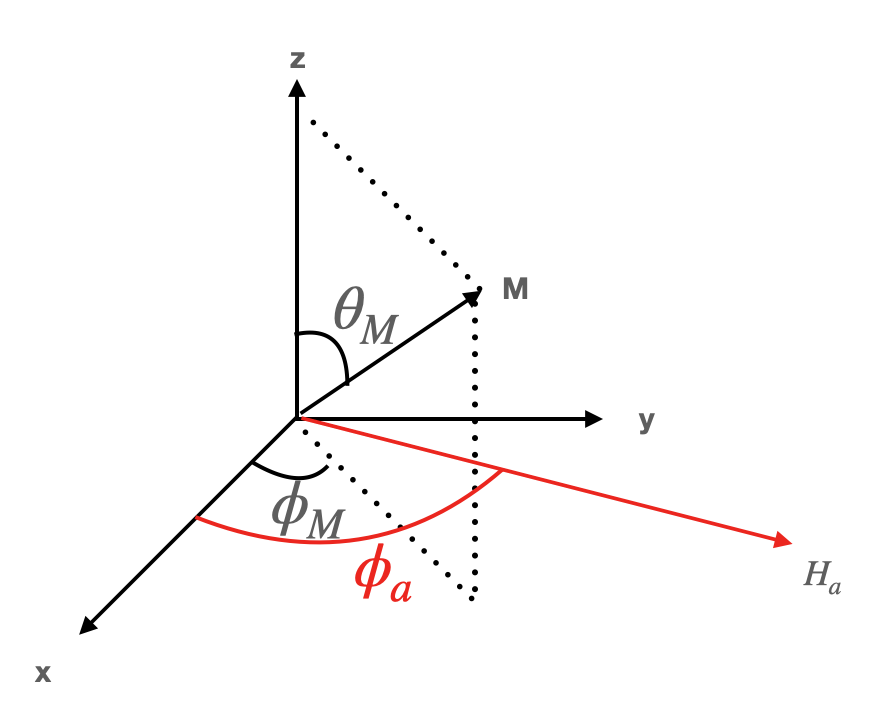

## Energy

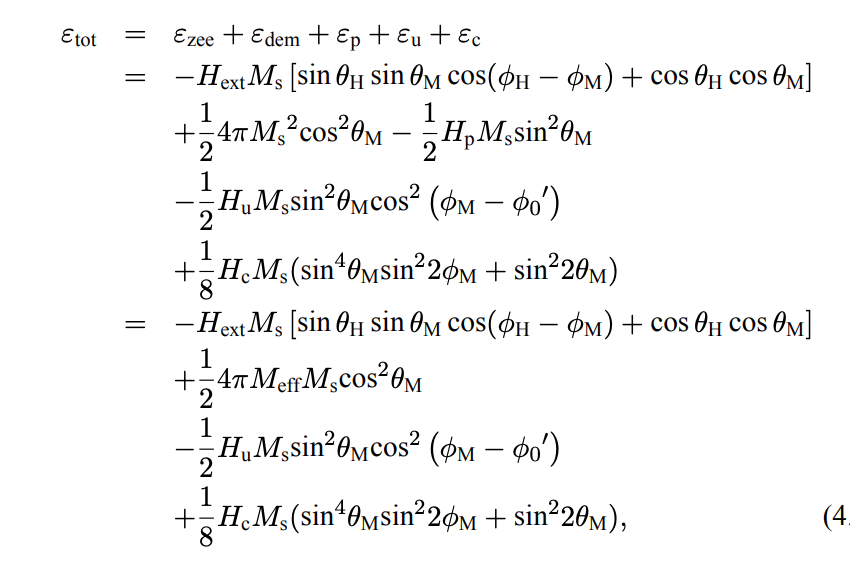

## Smit-Suhl

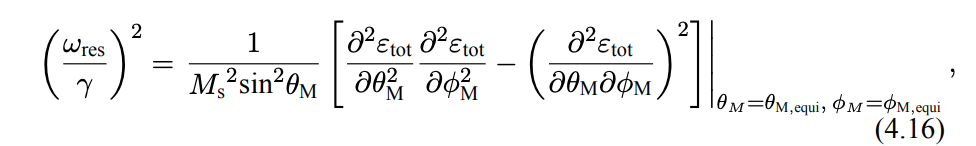

In [4]:
import sympy as sp
sp.init_printing()

In [57]:
def getfreqform(phiH,thetaH,phiHA):
    sp.var('H,M_s,theta_M,phi_M,theta_H,phi_H,phi_0,H_k,gamma',real=True)
    Etot=-H*M_s*(sp.cos(theta_M)*sp.cos(theta_H)+sp.sin(theta_M)*sp.sin(theta_H)*sp.cos(phi_M-phi_H))+\
    0.5*M_s*M_s*sp.cos(theta_M)**2-0.5*H_k*M_s*sp.sin(theta_M)**2*sp.cos(phi_M-phi_0)**2 

    ### get equilibrium angle for theta and phi
    eq1=sp.Eq(sp.diff(Etot, theta_M),0)
    eq2=sp.Eq(sp.diff(Etot, phi_M),0)

    eq1sub=sp.simplify(eq1.subs([(theta_M,thetaH),(theta_H,thetaH),(phi_0,phiHA),(phi_H,phiH)]))
    eq2sub=sp.simplify(eq2.subs([(theta_M,thetaH),(theta_H,thetaH),(phi_0,phiHA),(phi_H,phiH)]))

    dE2_dtheta2=sp.diff(sp.diff(Etot, theta_M),theta_M)
    dE2_dphi2=sp.diff(sp.diff(Etot, phi_M),phi_M)
    dE2_dphi_dtheta=sp.diff(sp.diff(Etot, theta_M),phi_M)

    freq=gamma/2/sp.pi/M_s/sp.sin(theta_M)*sp.sqrt(dE2_dtheta2*dE2_dphi2 - dE2_dphi_dtheta**2)

    freq2=freq.subs([(theta_H,thetaH),(theta_M,thetaH),(phi_H,phiH),\
                     (phi_M,sp.solve(eq2sub,phi_M)[0]),(phi_0,0)])

    return freq2


In [61]:
# Parallel to Ha
form1=getfreqform(0,sp.pi/2,0)

# Perpendicular to Ha
form2=getfreqform(sp.pi/2,sp.pi/2,0)

# 45 to Ha
form3=getfreqform(sp.pi/4,sp.pi/2,0)

## Plot

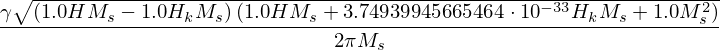

In [76]:
form2

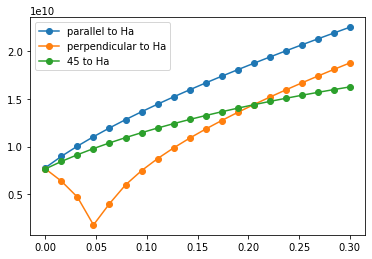

In [74]:
gamma0=28e9*2*np.pi
hlist=np.linspace(0,0.3,20)
M0=1.5
Hk=0.05

freqlist=[float(np.abs(sp.simplify(form1.subs([(H,x),(M_s,M0),(gamma,gamma0),(H_k,0.05)])))) for x in hlist]
plt.plot(hlist,freqlist,'o-',label='parallel to Ha')

freqlist=[float(np.abs(sp.simplify(form2.subs([(H,x),(M_s,M0),(gamma,gamma0),(H_k,0.05)])))) for x in hlist]
plt.plot(hlist,freqlist,'o-',label='perpendicular to Ha')

freqlist=[float(np.abs(sp.simplify(form3.subs([(H,x),(M_s,M0),(gamma,gamma0),(H_k,0.05)])))) for x in hlist]

plt.plot(hlist,freqlist,'o-',label='45 to Ha')

plt.legend()

# Kal

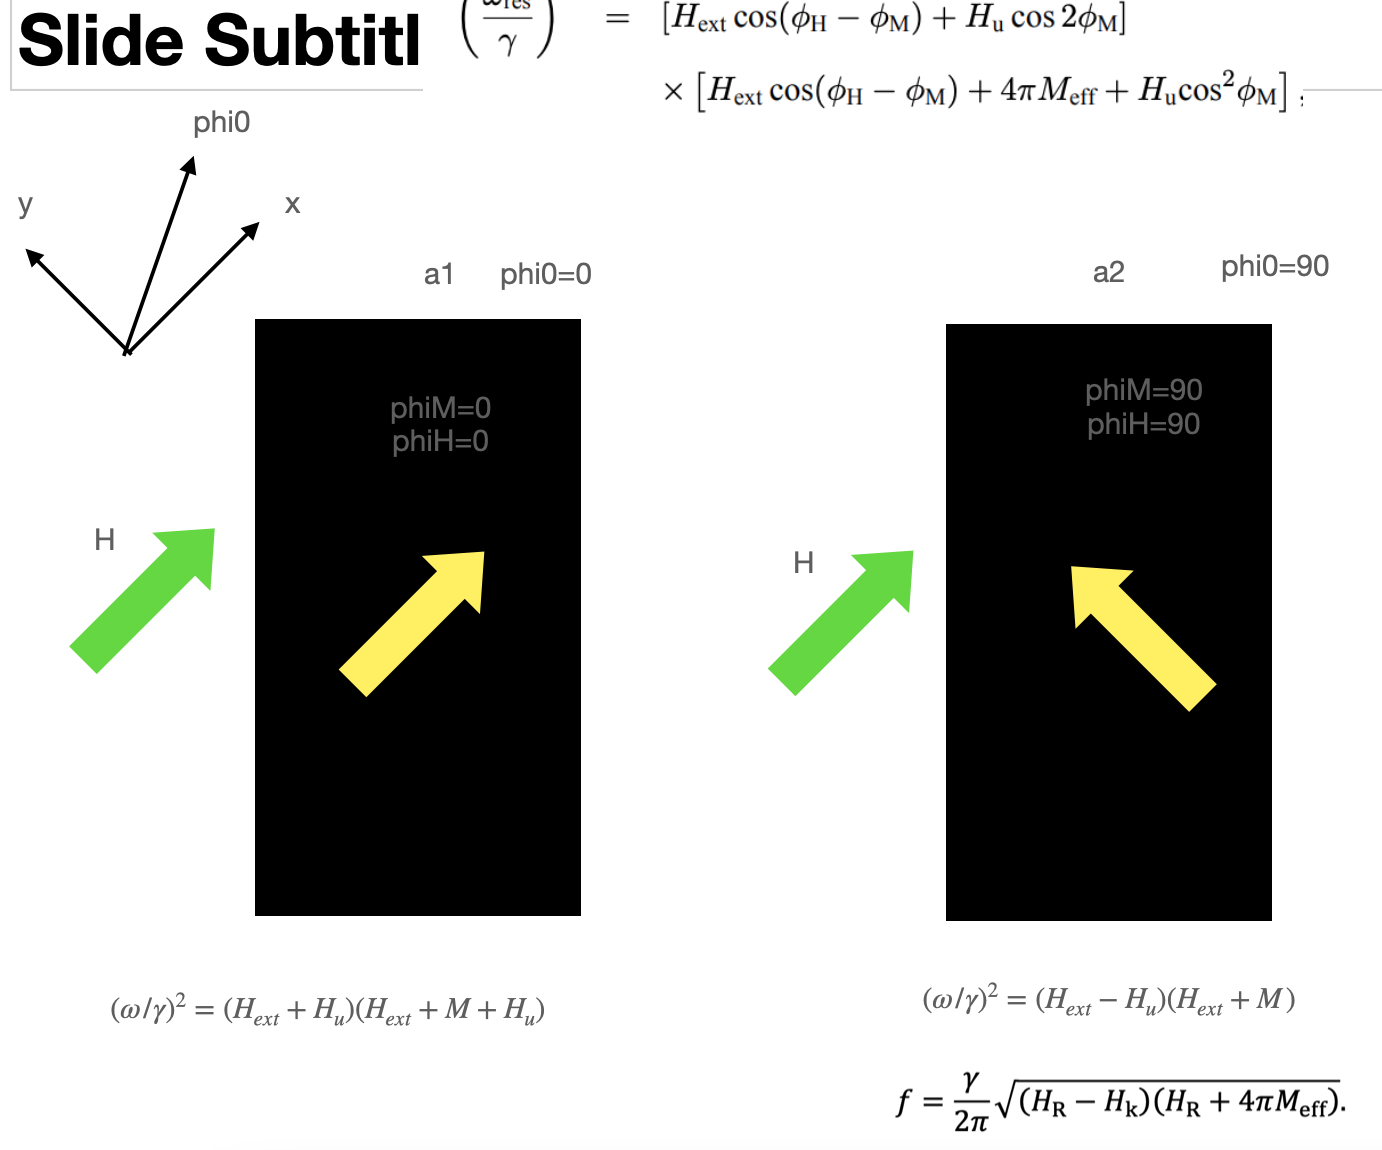

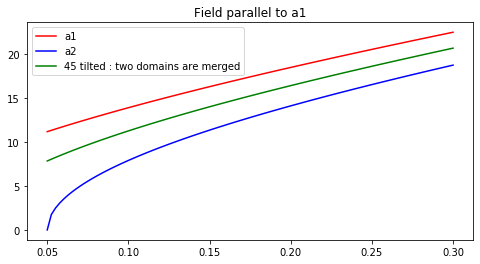

In [88]:
plt.figure(figsize=(8,4))

############# theory
# Parameters
mu0 = 4*np.pi*10**-7;#H/m
g= 28;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958 
muM = 1.5; #Wettling,M.G.Cottam,and J.R.Sandercock,J.Phy8,211 (1975) *)
AYIG = 0.37*10**-11;
dexYIG = 2*AYIG/(muM/mu0)#T m^2 in W.Wes.C:Solid State Phys.8,211 (1975)
thickFe = 10e-9 #meter;

# freqlist = KS_Freq(gYIG,0.1e1,0.1,0,muM,muHlist/1000,dexYIG,thickFe,90*np.pi/180)
plt.title('Field parallel to a1')
Han=0.05
muHlist=np.linspace(Han,0.3,100)
freqlist = g*np.sqrt((Han+muHlist)*(muHlist+muM+Han))
plt.plot(muHlist,freqlist,'r',label='a1')
freqlist = g*np.sqrt((muHlist-Han)*(muHlist+muM))
plt.plot(muHlist,freqlist,'b',label='a2')
freqlist = g*np.sqrt((muHlist)*(muHlist+muM+Han/2))
plt.plot(muHlist,freqlist,'g',label='45 tilted : two domains are merged')
plt.legend()

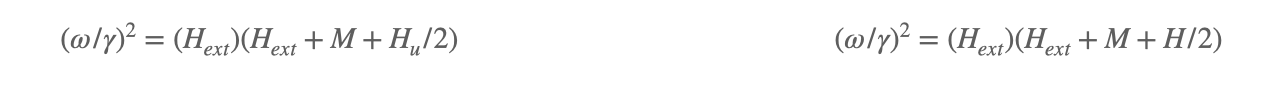